<a href="https://colab.research.google.com/github/maxsanchezdp/music_classifier/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16


Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

def split_songs(X, y, window = 0.1, overlap = 0.5):
    """
    Function to split a song into multiple songs.
    """
    # Temporary lists to hold results
    temp_X = []
    temp_y = []

    # Get input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [0]:
def melspectrogram(songs, n_fft = 1024, hop_length = 512):
    """
    Function to convert a list of songs to an array of melspectrograms
    """
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft = n_fft, hop_length = hop_length)[:,:,np.newaxis]

    # map function to songs
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

In [0]:
def read_data(src_dir, genres, song_samples, spec_format, debug = False):
    """
    Function to read songs, split them, create melspectrograms and saving X and y to np.arrays
    """
    # Empty array to create np.arrays
    arr_specs = []
    arr_genres = []

    # Read files
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                signal = signal[:song_samples] #keep only specified length of song array
                
                # Debug 
                if debug:
                    print(f"Reading file: {file_name}")
                
                # Split songs
                signals, y = split_songs(signal, genres[x])
                
                # Convert to melspectrograms
                specs = spec_format(signals)
                
                # Save files
                arr_genres.extend(y)
                arr_specs.extend(specs)
                
                
    return np.array(arr_specs), np.array(arr_genres)

In [0]:
# Parameters
audio_dir = '/content/drive/My Drive/final_project_dataset/genres/' #/content/drive/My Drive/final_project_dataset/genres/
song_samples = 660000
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

In [0]:
# Read the data
X, y = read_data(audio_dir, genres, song_samples, melspectrogram, debug=True)
np.save('/content/drive/My Drive/x_audio_npy.npy', X)#/content/drive/My Drive/x_audio_npy.npy
np.save('/content/drive/My Drive/y_audio_npy.npy', y)#/content/drive/My Drive/y_audio_npy.npy

In [0]:

X = np.load('/content/drive/My Drive/x_audio_npy.npy')#/content/drive/My Drive/x_audio_npy.npy
y = np.load('/content/drive/My Drive/y_audio_npy.npy')#/content/drive/My Drive/y_audio_npy.npy

In [0]:
# One hot encoding of song labels 
y = to_categorical(y)

In [8]:
X_stack = np.squeeze(np.stack((X,) * 3, -1))
X_stack.shape

(19000, 128, 129, 3)

In [0]:

X_train, X_test, y_train, y_test = train_test_split(X_stack, y, test_size=0.3, random_state=42, stratify = y)

In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13300, 128, 129, 3) (5700, 128, 129, 3) (13300, 10) (5700, 10)


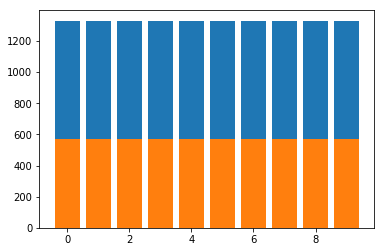

In [11]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [16]:
input_shape = X_train[0].shape
num_genres = 10

def cnn_vgg16(input_shape, num_genres, freezed_layers):
    input_tensor = Input(shape=input_shape)
    vgg16 = VGG16(include_top=False, weights='imagenet',
                  input_tensor=input_tensor)

    top = Sequential()
    top.add(Flatten(input_shape=vgg16.output_shape[1:]))
    top.add(Dense(128, activation='relu'))
    top.add(Dropout(0.5))
    top.add(Dense(num_genres, activation='softmax'))

    model = Model(inputs=vgg16.input, outputs=top(vgg16.output))
    for layer in model.layers[:freezed_layers]:
        layer.trainable = False

    return model

model = cnn_vgg16(input_shape, num_genres, 5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 129, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 129, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 129, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [17]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 13300 samples, validate on 5700 samples
Epoch 1/50
13300/13300 [==============================] - 53s 4ms/step - loss: 2.1691 - acc: 0.2538 - val_loss: 1.7334 - val_acc: 0.3665
Epoch 2/50
13300/13300 [==============================] - 52s 4ms/step - loss: 1.7218 - acc: 0.3688 - val_loss: 1.4580 - val_acc: 0.4884
Epoch 3/50
13300/13300 [==============================] - 52s 4ms/step - loss: 1.4779 - acc: 0.4728 - val_loss: 1.3297 - val_acc: 0.5179
Epoch 4/50
13300/13300 [==============================] - 52s 4ms/step - loss: 1.3060 - acc: 0.5367 - val_loss: 1.1761 - val_acc: 0.5900
Epoch 5/50
13300/13300 [==============================] - 52s 4ms/step - loss: 1.1902 - acc: 0.5789 - val_loss: 1.0658 - val_acc: 0.6249
Epoch 6/50
13300/13300 [==============================] - 52s 4ms/step - loss: 1.1005 - acc: 0.6171 - val_loss: 0.9947 - val_acc: 0.6486
Epoch 7/50
13300/13300 [==============================] - 52s 4ms/step - loss: 0.9754 - acc: 0.6628 - val_loss: 0.8917 - val_acc:

In [18]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.469 and val_acc = 0.874


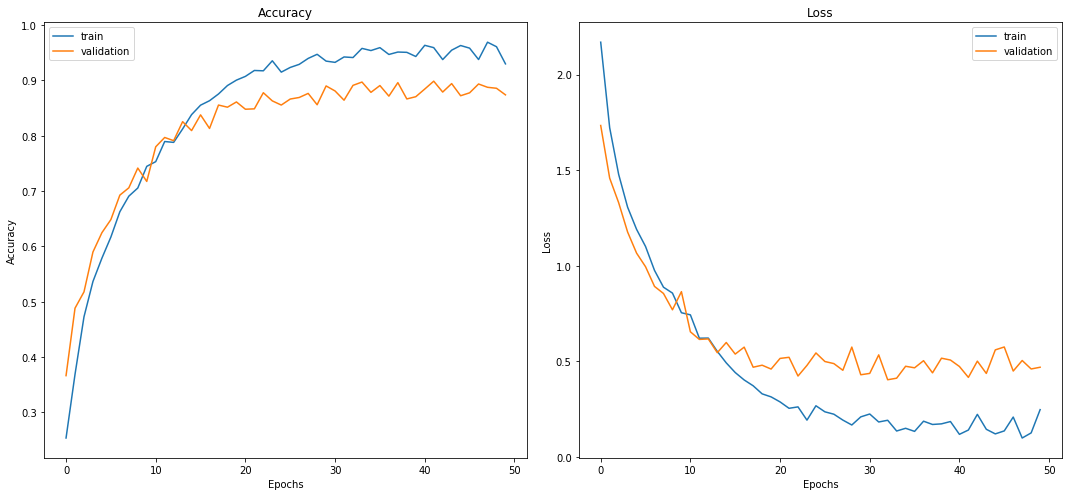

In [19]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [0]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(y_orig, preds)

Normalized confusion matrix


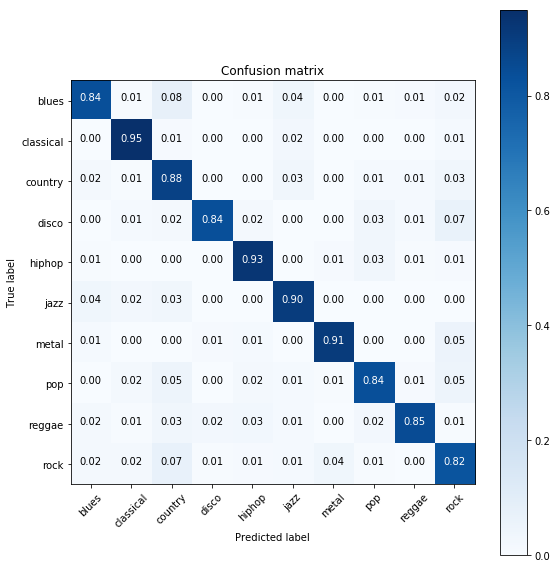

In [22]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

In [0]:
# Save the model
model.save('/content/drive/My Drive/modelo_vgg16.h5')#cambiar path